In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

In [5]:
df = pd.read_csv('news.csv')
df = df.iloc[:1000]
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [6]:
# Выбираем столбец с текстом для векторизации
texts = df['text']
texts

0      Daniel Greenfield, a Shillman Journalism Fello...
1      Google Pinterest Digg Linkedin Reddit Stumbleu...
2      U.S. Secretary of State John F. Kerry said Mon...
3      — Kaydee King (@KaydeeKing) November 9, 2016 T...
4      It's primary day in New York and front-runners...
                             ...                        
995    Clintons Are Under Multiple FBI Investigations...
996    Military: Goal Is to 'Liberate' Eastern Bank o...
997    SHOCK VIDEO : Hillary Needs Help Climbing ONE ...
998    President Obama’s decision to expand the U.S. ...
999    geoengineeringwatch.org \nGlobal climate engin...
Name: text, Length: 1000, dtype: object

In [7]:
def remove_non_english_words(text):
    return ' '.join(re.findall(r'\b[a-zA-Z]+\b', text))

# Применяем функцию к каждому тексту в столбце texts
texts = df['text'].apply(remove_non_english_words)

In [8]:
# Применим CountVectorizer для работы со всеми словами с учетом регистра
vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(texts)

In [9]:
X_count_df = pd.DataFrame(X_count.toarray(), columns=vectorizer.get_feature_names_out())
columns = X_count_df.columns.tolist()
sorted(columns, key=lambda x: (not x[0].isalpha(), x))[:100]

['aa',
 'aaa',
 'aamaq',
 'aaron',
 'aarp',
 'aaso',
 'aau',
 'abaaoud',
 'ababa',
 'aback',
 'abadi',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abandons',
 'abate',
 'abated',
 'abating',
 'abbas',
 'abbey',
 'abbott',
 'abbreviation',
 'abby',
 'abc',
 'abcpolitics',
 'abdelhamid',
 'abdeslam',
 'abdiwahab',
 'abdollahi',
 'abducted',
 'abduction',
 'abductor',
 'abdul',
 'abdulazeez',
 'abdulaziz',
 'abdulla',
 'abdullah',
 'abe',
 'abedin',
 'abelah',
 'aberration',
 'aberrational',
 'abeslam',
 'abetted',
 'abetting',
 'abha',
 'abhor',
 'abhorrent',
 'abhors',
 'abide',
 'abiding',
 'abilities',
 'ability',
 'abiotic',
 'abject',
 'ablaze',
 'able',
 'ableism',
 'ablow',
 'ably',
 'abm',
 'abner',
 'abnormal',
 'abnormalities',
 'aboard',
 'abode',
 'abolish',
 'abolished',
 'abolishing',
 'abolition',
 'abomination',
 'aboriginal',
 'aborigine',
 'aborigines',
 'aborted',
 'abortion',
 'abortions',
 'abortive',
 'abortively',
 'abound',
 'abounds',
 'about',
 'a

In [10]:
# Вариант 2: Приведение всех слов к одному регистру
vectorizer_lowercase = CountVectorizer(lowercase=True)
X_count_lowercase = vectorizer_lowercase.fit_transform(texts)
X_count_lowercase_df = pd.DataFrame(X_count_lowercase.toarray(), columns=vectorizer_lowercase.get_feature_names_out())

In [11]:
# Вариант 3: Удаление стоп-слов
vectorizer_stopwords = CountVectorizer(lowercase=True, stop_words='english')
X_count_stopwords = vectorizer_stopwords.fit_transform(texts)
X_count_stopwords_df = pd.DataFrame(X_count_stopwords.toarray(), columns=vectorizer_stopwords.get_feature_names_out())

In [12]:
# Вариант 4: Выделение только специфичных слов с помощью TF-IDF (отбор наиболее значимых слов)
tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_features=1000) # Можно настроить max_features для специфики
X_tfidf = tfidf_vectorizer.fit_transform(texts)
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

In [14]:
# Модели классификации
models = {
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=500),
    'SVM': SVC(kernel='linear')
}

In [32]:
def train_and_evaluate(X, y, feature_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    results = {}
    num_features = X_train.shape[1]
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Оценка важности признаков (если поддерживается)
        if model_name == 'Random Forest':
            importance = model.feature_importances_
        elif model_name in ['Logistic Regression', 'SVM']:
            importance = np.abs(model.coef_[0])  # Для логистической регрессии и SVM
        elif model_name == 'Naive Bayes':
            # Разница логарифмов вероятностей между классами для каждого признака
            if model.feature_log_prob_.shape[0] == 2:  # Бинарная классификация
                importance = np.abs(model.feature_log_prob_[0] - model.feature_log_prob_[1])
            else:  # Многоклассовая классификация
                importance = np.var(model.feature_log_prob_, axis=0)  # Используем дисперсию по классам
        else:
            importance = None
        
        # Сохраняем метрики классификации и информацию о признаках
        results[model_name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'num_features': num_features,
            'importance': importance,
            'feature_names': feature_names 
        }
    
    return results

In [33]:
# Преобразуем метки классов в числовой формат
y = df['label'].replace({'REAL': 1, 'FAKE': 0})

/var/folders/m6/1s9x17dj7nz6tz80sl70pmzmhr757m/T/ipykernel_32392/1516760148.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['label'].replace({'REAL': 1, 'FAKE': 0})


In [34]:
results = {}

In [35]:
results['Original'] = train_and_evaluate(X_count_df, y, vectorizer.get_feature_names_out())

In [36]:
# Вариант 2: Приведение к одному регистру
results['Lowercase'] = train_and_evaluate(X_count_lowercase_df, y, vectorizer_lowercase.get_feature_names_out())

In [37]:
# Вариант 3: Удаление стоп-слов
results['Stopwords removed'] = train_and_evaluate(X_count_stopwords_df, y, vectorizer_stopwords.get_feature_names_out())

In [38]:
# Вариант 4: Специфичные слова (TF-IDF)
results['TF-IDF'] = train_and_evaluate(X_tfidf_df, y, tfidf_vectorizer.get_feature_names_out())


Результаты для варианта предобработки: Original

Модель: Naive Bayes
Accuracy: 0.8800
Количество признаков: 30032
Важность признаков для модели Naive Bayes:
Признак: lesley, Важность: 5.2111
Признак: stahl, Важность: 5.1974
Признак: vitamin, Важность: 4.4401
Признак: infowars, Важность: 4.2811
Признак: www, Важность: 4.0273
Признак: weiner, Важность: 3.7760
Признак: https, Важность: 3.7171
Признак: vermont, Важность: 3.6712
Признак: protectors, Важность: 3.6218
Признак: emissions, Важность: 3.6080


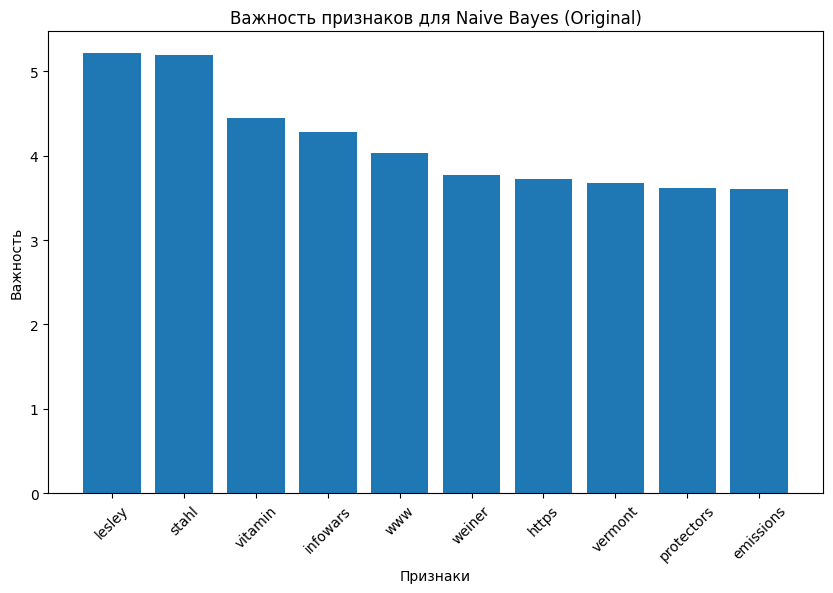


Модель: Random Forest
Accuracy: 0.7700
Количество признаков: 30032
Важность признаков для модели Random Forest:
Признак: said, Важность: 0.0075
Признак: and, Важность: 0.0058
Признак: in, Важность: 0.0058
Признак: sen, Важность: 0.0055
Признак: president, Важность: 0.0054
Признак: but, Важность: 0.0048
Признак: campaign, Важность: 0.0048
Признак: ted, Важность: 0.0045
Признак: administration, Важность: 0.0044
Признак: who, Важность: 0.0044


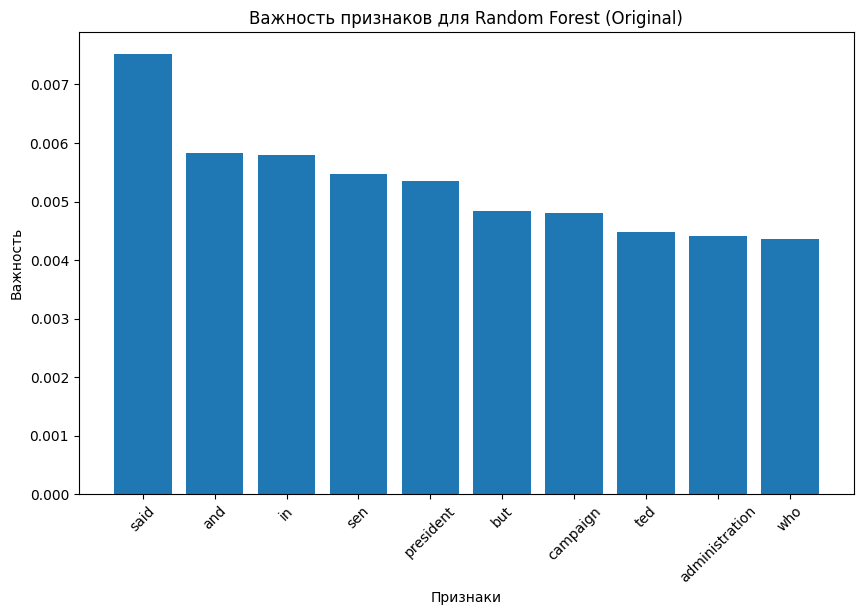


Модель: Logistic Regression
Accuracy: 0.8133
Количество признаков: 30032
Важность признаков для модели Logistic Regression:
Признак: october, Важность: 0.6731
Признак: administration, Важность: 0.6409
Признак: verdict, Важность: 0.6107
Признак: by, Важность: 0.5710
Признак: startups, Важность: 0.5320
Признак: sweeping, Важность: 0.5296
Признак: candidates, Важность: 0.5179
Признак: consequences, Важность: 0.5120
Признак: tech, Важность: 0.5118
Признак: us, Важность: 0.5001


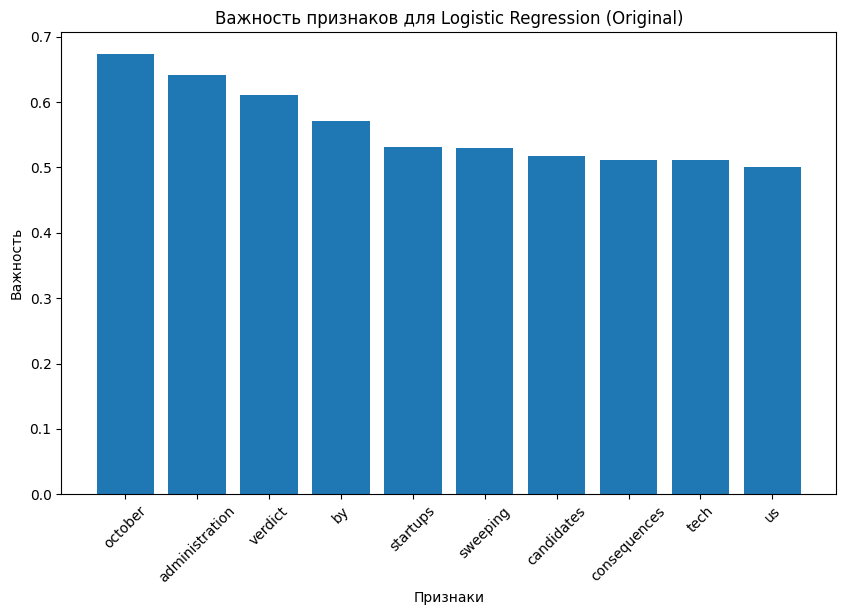


Модель: SVM
Accuracy: 0.7967
Количество признаков: 30032
Важность признаков для модели SVM:
Признак: administration, Важность: 0.3546
Признак: fits, Важность: 0.3494
Признак: platform, Важность: 0.3270
Признак: closely, Важность: 0.3230
Признак: verdict, Важность: 0.3144
Признак: online, Важность: 0.3119
Признак: sweeping, Важность: 0.3045
Признак: startups, Важность: 0.3045
Признак: consequences, Важность: 0.3005
Признак: tech, Важность: 0.2971


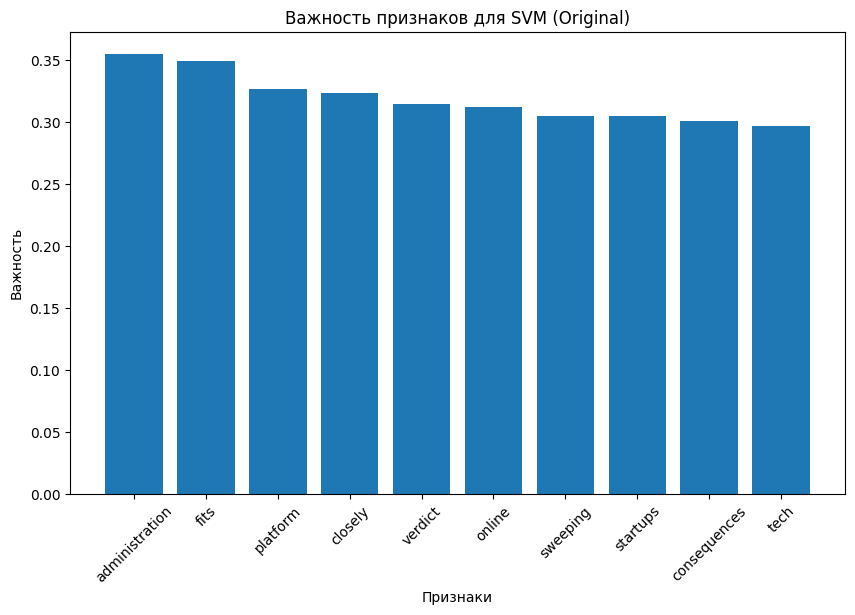


Результаты для варианта предобработки: Lowercase

Модель: Naive Bayes
Accuracy: 0.8800
Количество признаков: 30032
Важность признаков для модели Naive Bayes:
Признак: lesley, Важность: 5.2111
Признак: stahl, Важность: 5.1974
Признак: vitamin, Важность: 4.4401
Признак: infowars, Важность: 4.2811
Признак: www, Важность: 4.0273
Признак: weiner, Важность: 3.7760
Признак: https, Важность: 3.7171
Признак: vermont, Важность: 3.6712
Признак: protectors, Важность: 3.6218
Признак: emissions, Важность: 3.6080


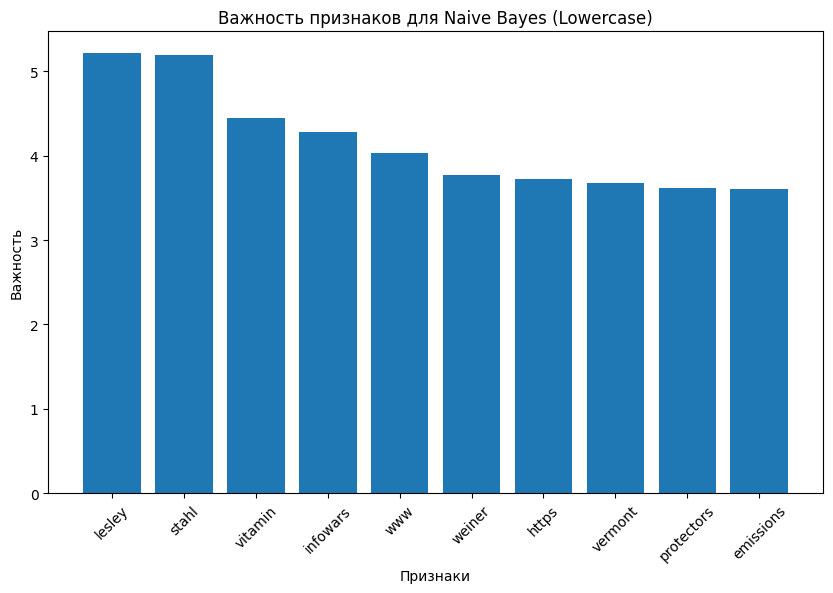


Модель: Random Forest
Accuracy: 0.7900
Количество признаков: 30032
Важность признаков для модели Random Forest:
Признак: said, Важность: 0.0083
Признак: in, Важность: 0.0063
Признак: republican, Важность: 0.0059
Признак: candidates, Важность: 0.0059
Признак: cruz, Важность: 0.0052
Признак: for, Важность: 0.0047
Признак: october, Важность: 0.0045
Признак: sen, Важность: 0.0044
Признак: the, Важность: 0.0044
Признак: and, Важность: 0.0044


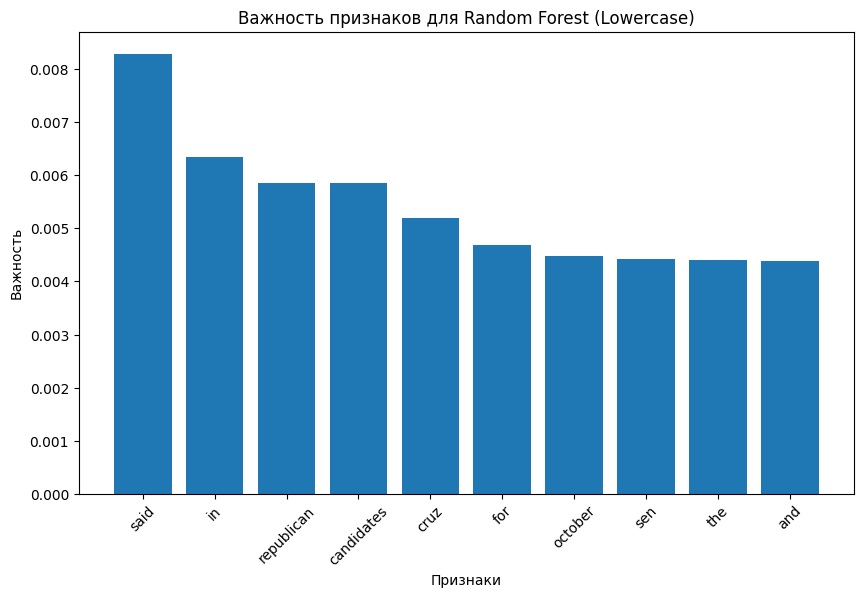


Модель: Logistic Regression
Accuracy: 0.8133
Количество признаков: 30032
Важность признаков для модели Logistic Regression:
Признак: october, Важность: 0.6731
Признак: administration, Важность: 0.6409
Признак: verdict, Важность: 0.6107
Признак: by, Важность: 0.5710
Признак: startups, Важность: 0.5320
Признак: sweeping, Важность: 0.5296
Признак: candidates, Важность: 0.5179
Признак: consequences, Важность: 0.5120
Признак: tech, Важность: 0.5118
Признак: us, Важность: 0.5001


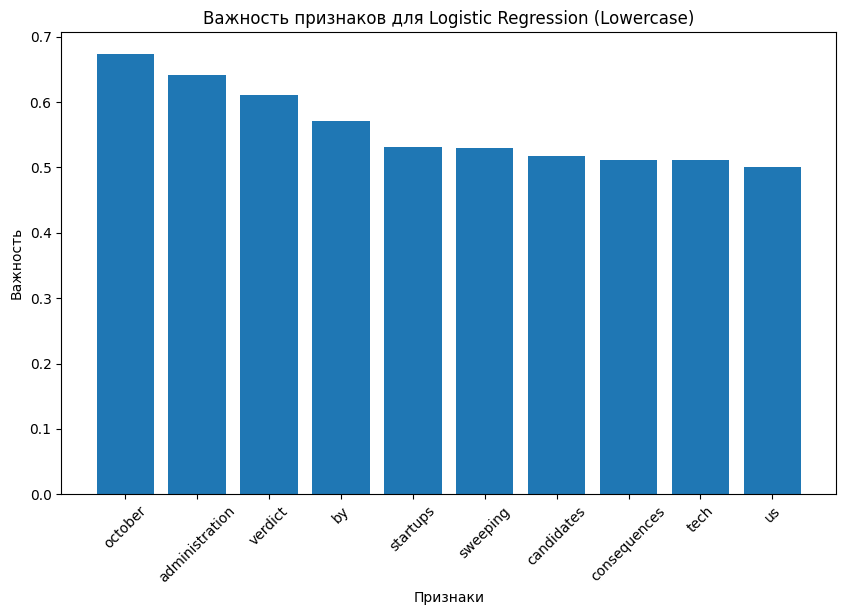


Модель: SVM
Accuracy: 0.7967
Количество признаков: 30032
Важность признаков для модели SVM:
Признак: administration, Важность: 0.3546
Признак: fits, Важность: 0.3494
Признак: platform, Важность: 0.3270
Признак: closely, Важность: 0.3230
Признак: verdict, Важность: 0.3144
Признак: online, Важность: 0.3119
Признак: sweeping, Важность: 0.3045
Признак: startups, Важность: 0.3045
Признак: consequences, Важность: 0.3005
Признак: tech, Важность: 0.2971


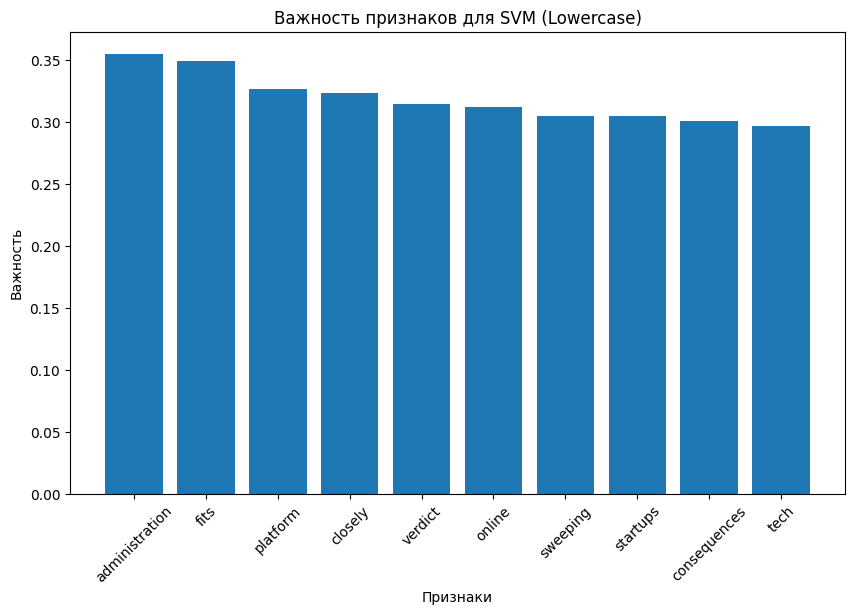


Результаты для варианта предобработки: Stopwords removed

Модель: Naive Bayes
Accuracy: 0.8800
Количество признаков: 29730
Важность признаков для модели Naive Bayes:
Признак: lesley, Важность: 5.2026
Признак: stahl, Важность: 5.1889
Признак: vitamin, Важность: 4.4317
Признак: infowars, Важность: 4.2726
Признак: www, Важность: 4.0188
Признак: weiner, Важность: 3.7675
Признак: https, Важность: 3.7087
Признак: vermont, Важность: 3.6797
Признак: emissions, Важность: 3.6165
Признак: protectors, Важность: 3.6133


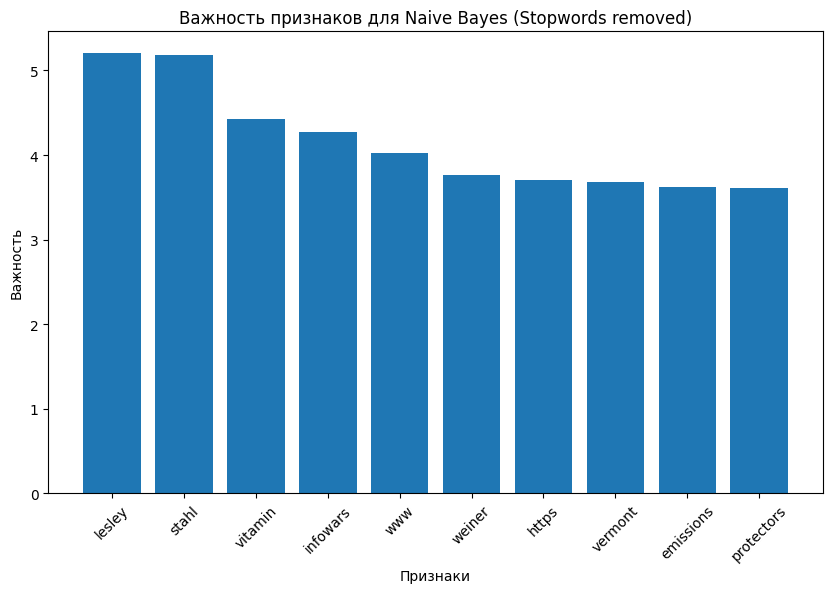


Модель: Random Forest
Accuracy: 0.7700
Количество признаков: 29730
Важность признаков для модели Random Forest:
Признак: said, Важность: 0.0101
Признак: republican, Важность: 0.0066
Признак: sen, Важность: 0.0065
Признак: candidates, Важность: 0.0058
Признак: cruz, Важность: 0.0052
Признак: startups, Важность: 0.0047
Признак: nomination, Важность: 0.0045
Признак: spokesman, Важность: 0.0045
Признак: verdict, Важность: 0.0042
Признак: administration, Важность: 0.0041


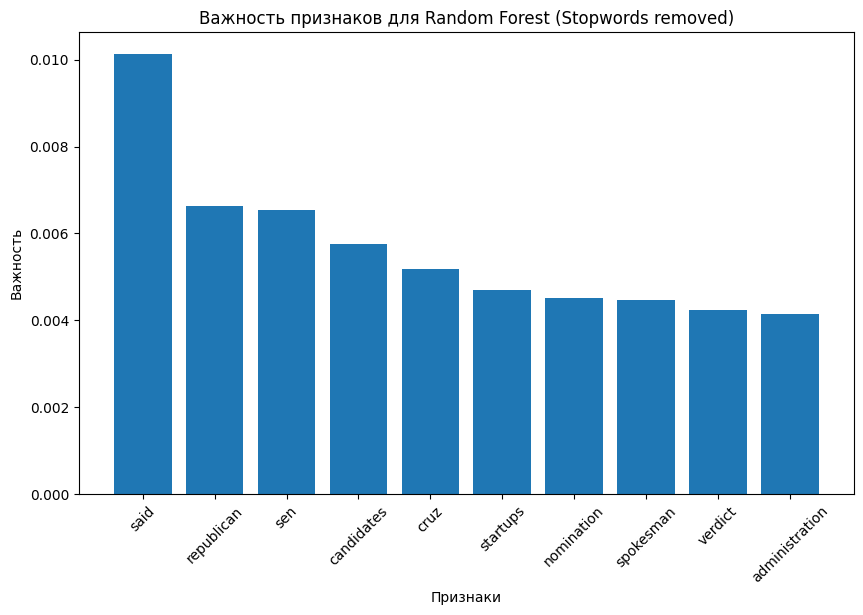


Модель: Logistic Regression
Accuracy: 0.8533
Количество признаков: 29730
Важность признаков для модели Logistic Regression:
Признак: candidates, Важность: 0.7046
Признак: administration, Важность: 0.6996
Признак: verdict, Важность: 0.6683
Признак: october, Важность: 0.6478
Признак: startups, Важность: 0.6165
Признак: sweeping, Важность: 0.6155
Признак: tech, Важность: 0.5823
Признак: consequences, Важность: 0.5753
Признак: hillary, Важность: 0.5681
Признак: exchanges, Важность: 0.5510


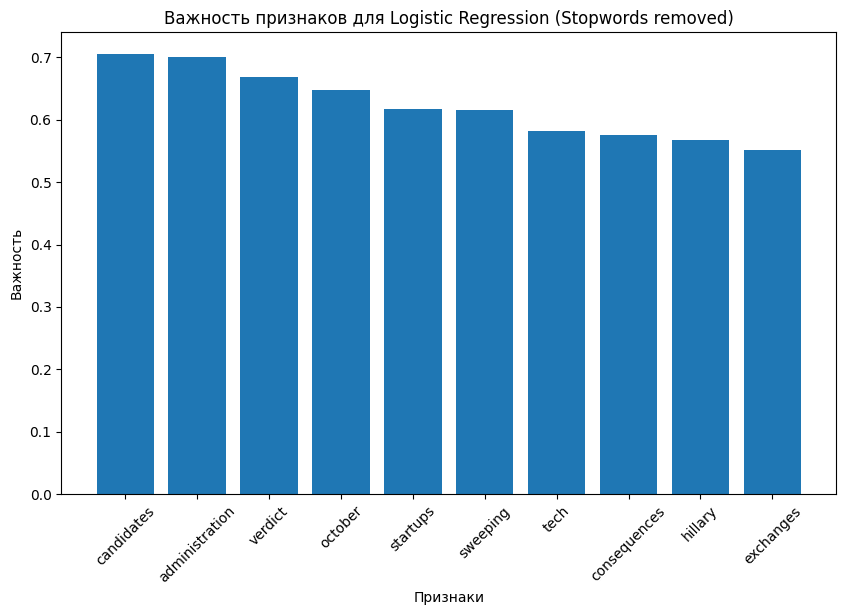


Модель: SVM
Accuracy: 0.7900
Количество признаков: 29730
Важность признаков для модели SVM:
Признак: administration, Важность: 0.4679
Признак: candidates, Важность: 0.4669
Признак: demolish, Важность: 0.4348
Признак: exchanges, Важность: 0.4251
Признак: easier, Важность: 0.4193
Признак: verdict, Важность: 0.4161
Признак: sweeping, Важность: 0.4012
Признак: startups, Важность: 0.4008
Признак: quotes, Важность: 0.3993
Признак: numbers, Важность: 0.3962


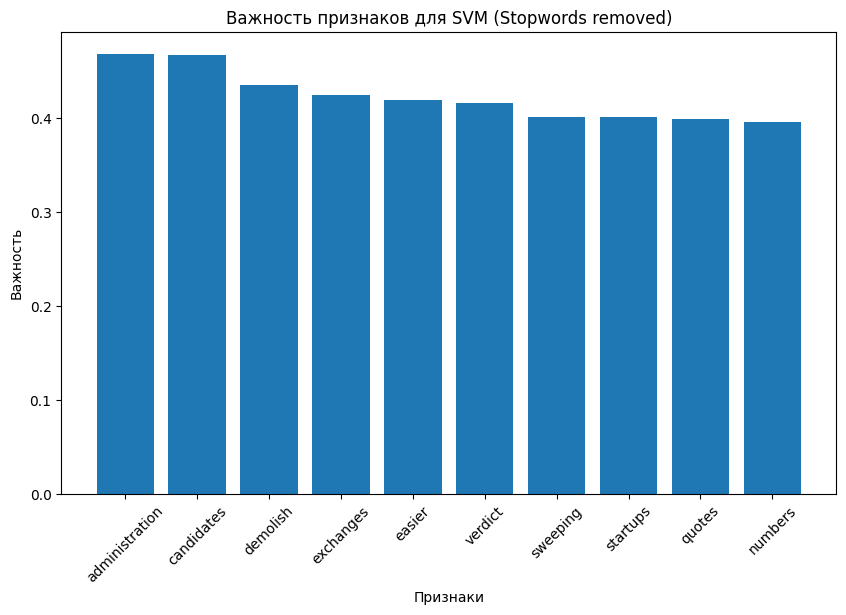


Результаты для варианта предобработки: TF-IDF

Модель: Naive Bayes
Accuracy: 0.8433
Количество признаков: 1000
Важность признаков для модели Naive Bayes:
Признак: cruz, Важность: 2.2535
Признак: sanders, Важность: 1.9018
Признак: october, Важность: 1.8452
Признак: delegates, Важность: 1.8426
Признак: sen, Важность: 1.7513
Признак: com, Важность: 1.7280
Признак: kasich, Важность: 1.6770
Признак: weiner, Важность: 1.6725
Признак: wikileaks, Важность: 1.6521
Признак: rubio, Важность: 1.6441


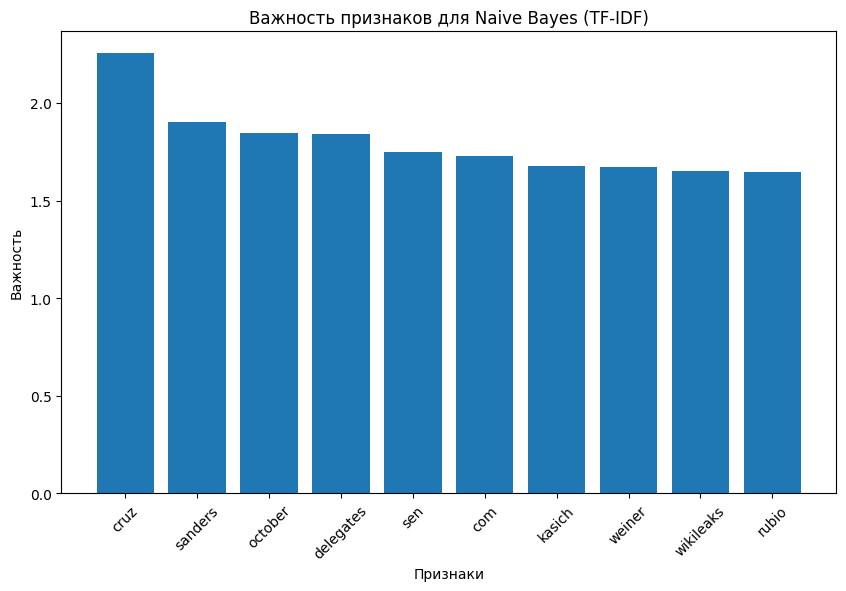


Модель: Random Forest
Accuracy: 0.8533
Количество признаков: 1000
Важность признаков для модели Random Forest:
Признак: said, Важность: 0.0234
Признак: october, Важность: 0.0202
Признак: republican, Важность: 0.0153
Признак: sen, Важность: 0.0129
Признак: administration, Важность: 0.0108
Признак: candidates, Важность: 0.0104
Признак: campaign, Важность: 0.0103
Признак: obama, Важность: 0.0101
Признак: ted, Важность: 0.0094
Признак: cruz, Важность: 0.0093


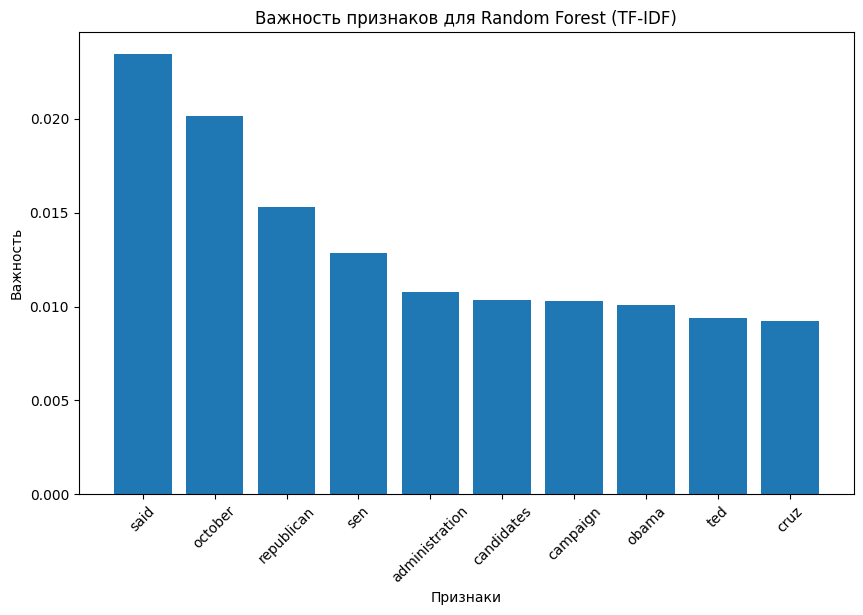


Модель: Logistic Regression
Accuracy: 0.8667
Количество признаков: 1000
Важность признаков для модели Logistic Regression:
Признак: said, Важность: 3.3110
Признак: hillary, Важность: 1.9221
Признак: october, Важность: 1.8628
Признак: sanders, Важность: 1.6741
Признак: campaign, Важность: 1.5482
Признак: cruz, Важность: 1.4584
Признак: com, Важность: 1.4403
Признак: republican, Важность: 1.4011
Признак: candidates, Важность: 1.3182
Признак: election, Важность: 1.3166


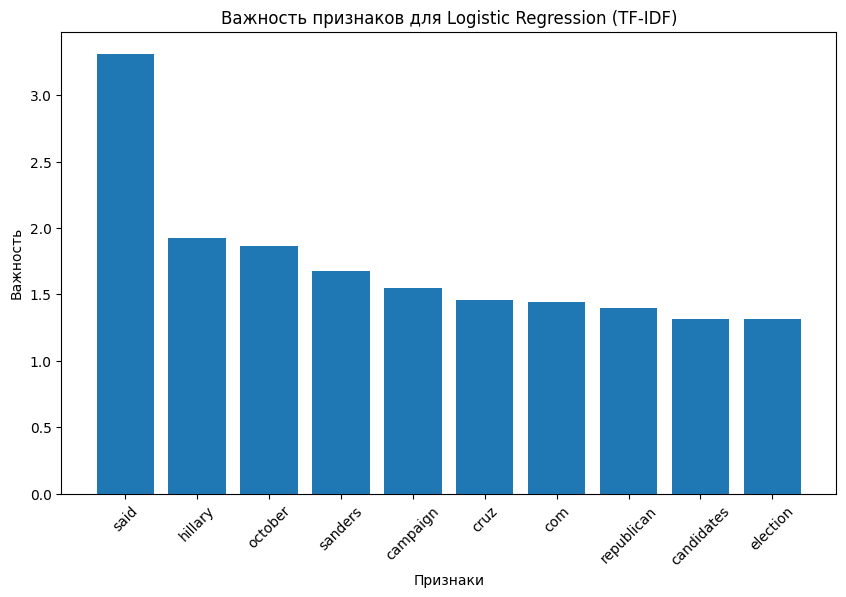


Модель: SVM
Accuracy: 0.8633
Количество признаков: 1000
Важность признаков для модели SVM:
Признак: said, Важность: 2.9467
Признак: hillary, Важность: 1.8735
Признак: october, Важность: 1.7316
Признак: department, Важность: 1.5424
Признак: campaign, Важность: 1.5237
Признак: candidates, Важность: 1.4828
Признак: article, Важность: 1.4637
Признак: administration, Важность: 1.4550
Признак: wikileaks, Важность: 1.2871
Признак: war, Важность: 1.2845


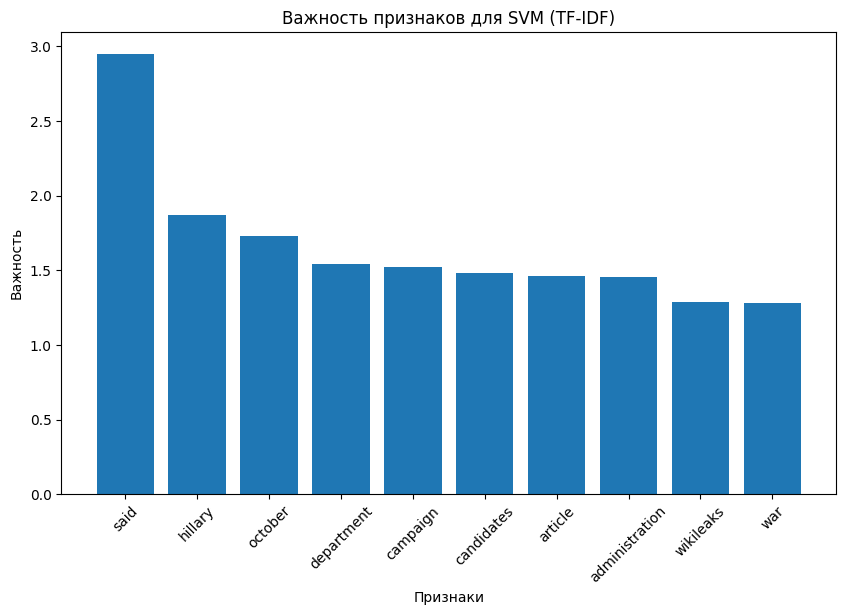

In [39]:
for preprocessing, models_results in results.items():
    print(f"\nРезультаты для варианта предобработки: {preprocessing}")
    for model_name, metrics in models_results.items():
        print(f"\nМодель: {model_name}")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Количество признаков: {metrics['num_features']}")
        
        # Определяем важность признаков для моделей, которые это поддерживают, и для Naive Bayes
        if metrics['importance'] is not None:
            print(f"Важность признаков для модели {model_name}:")
            importance = metrics['importance']
            sorted_indices = np.argsort(importance)[::-1]
            top_n = 10  # Выводим 10 наиболее важных признаков
            for i in range(top_n):
                print(f"Признак: {metrics['feature_names'][sorted_indices[i]]}, Важность: {importance[sorted_indices[i]]:.4f}")
            
            # Визуализация важности признаков
            plt.figure(figsize=(10, 6))
            plt.title(f'Важность признаков для {model_name} ({preprocessing})')
            plt.bar(range(top_n), importance[sorted_indices[:top_n]], align='center')
            plt.xticks(range(top_n), [metrics['feature_names'][i] for i in sorted_indices[:top_n]], rotation=45)
            plt.xlabel('Признаки')
            plt.ylabel('Важность')
            plt.show()
        
        elif model_name == "Naive Bayes":
            print(f"Псевдо-важность признаков для модели {model_name} (основано на коэффициентах вероятностей):")
            importance = np.abs(metrics['feature_log_prob_']).mean(axis=0)  # Среднее по классам
            sorted_indices = np.argsort(importance)[::-1]
            top_n = 10  # Выводим 10 наиболее значимых признаков
            
            for i in range(top_n):
                print(f"Признак: {metrics['feature_names'][sorted_indices[i]]}, Псевдо-важность: {importance[sorted_indices[i]]:.4f}")
            
            # Визуализация псевдо-важности признаков
            plt.figure(figsize=(10, 6))
            plt.title(f'Псевдо-важность признаков для {model_name} ({preprocessing})')
            plt.bar(range(top_n), importance[sorted_indices[:top_n]], align='center')
            plt.xticks(range(top_n), [metrics['feature_names'][i] for i in sorted_indices[:top_n]], rotation=45)
            plt.xlabel('Признаки')
            plt.ylabel('Псевдо-важность')
            plt.show()
        
        else:
            print(f"Модель {model_name} не поддерживает вывод важности признаков.")


In [40]:
# Разделим датасет на две части: для класса FAKE и REAL
fake_texts = df[df['label'] == 'FAKE']['text'].apply(remove_non_english_words)
real_texts = df[df['label'] == 'REAL']['text'].apply(remove_non_english_words)

In [41]:
# Применим векторизацию текста (используем нижний регистр и удаление стоп-слов для упрощения)
vectorizer = CountVectorizer(lowercase=True, stop_words='english')
X_fake = vectorizer.fit_transform(fake_texts)
X_real = vectorizer.transform(real_texts)

In [42]:
# Получим список всех слов
all_words = vectorizer.get_feature_names_out()

In [43]:
# Преобразуем в массивы
fake_word_counts = X_fake.toarray().sum(axis=0)
real_word_counts = X_real.toarray().sum(axis=0)

In [44]:
# # Найдем уникальные слова для каждого класса
# unique_fake_words = [all_words[i] for i in range(len(all_words)) if fake_word_counts[i] > 0 and real_word_counts[i] == 0]
# unique_real_words = [all_words[i] for i in range(len(all_words)) if real_word_counts[i] > 0 and fake_word_counts[i] == 0]

In [45]:
more_common_in_real = [all_words[i] for i in range(len(all_words)) if real_word_counts[i] > fake_word_counts[i]]
print(f"Слова, чаще встречающиеся в классе REAL: {more_common_in_real}")

Слова, чаще встречающиеся в классе REAL: ['aback', 'abandon', 'abandoning', 'abbas', 'abc', 'abducted', 'abhor', 'abiding', 'abilities', 'ability', 'able', 'aboard', 'abolish', 'aborted', 'abortion', 'abortions', 'abound', 'abruptly', 'absence', 'absentee', 'abu', 'abusing', 'abyss', 'accelerate', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'accidents', 'accommodate', 'accommodating', 'accommodation', 'accommodations', 'accompanied', 'accomplice', 'accomplices', 'accomplish', 'accomplished', 'accomplishment', 'accord', 'according', 'account', 'accountability', 'accounts', 'accumulate', 'accusation', 'accused', 'accustomed', 'achievement', 'acknowledged', 'acknowledging', 'acknowledgment', 'acquired', 'acquiring', 'acquisition', 'acquitted', 'acres', 'act', 'action', 'activist', 'activists', 'acute', 'ad', 'added', 'addiction', 'adding', 'addition', 'additional', 'address', 'addressed', 'addressing', 'adds', 'adequate', 'adjacent', 'administration', 'administrations',

In [46]:
# Найдем слова, которые чаще встречаются в классе FAKE, чем в классе REAL
more_common_in_fake = [all_words[i] for i in range(len(all_words)) if fake_word_counts[i] > real_word_counts[i]]

print(f"Слова, чаще встречающиеся в классе FAKE: {more_common_in_fake}")

Слова, чаще встречающиеся в классе FAKE: ['aa', 'aau', 'abandoned', 'abandonment', 'abandons', 'abated', 'abating', 'abbott', 'abbreviation', 'abcpolitics', 'abductor', 'abdul', 'abedin', 'abelah', 'aberrational', 'abhorrent', 'abiotic', 'abject', 'ablaze', 'ableism', 'abm', 'abode', 'abolished', 'abomination', 'aboriginal', 'aborigine', 'aborigines', 'abounds', 'aboutface', 'aboutmedia', 'aboutthe', 'abovetopsecret', 'abraham', 'abroad', 'absentia', 'absolute', 'absolutely', 'absorb', 'absorption', 'abstain', 'abstained', 'abstaining', 'abstains', 'abstention', 'absurd', 'absurdist', 'absurdities', 'absurdity', 'absurdly', 'abundance', 'abundant', 'abundantly', 'abuse', 'abused', 'abuses', 'abusive', 'abutting', 'abysmal', 'abysses', 'ac', 'aca', 'acab', 'academia', 'academic', 'academically', 'academicians', 'academics', 'academy', 'acai', 'acandemy', 'accelerating', 'accelerator', 'accepts', 'access', 'accessibility', 'accessible', 'accessories', 'accident', 'accidental', 'accomazzo

In [47]:
def evaluate_unique_words_importance(unique_words, feature_names, model, model_name, top_n=50):
    # Найдем индексы уникальных слов в feature_names
    unique_word_indices = [i for i, word in enumerate(feature_names) if word in unique_words]
    
    # Обработка для Random Forest
    if isinstance(model, RandomForestClassifier):
        importance = model.feature_importances_  # Используем feature_importances_ для Random Forest
        unique_word_indices = [i for i in unique_word_indices if i < len(importance)]  # Фильтруем индексы
        
    # Обработка для Logistic Regression и SVM
    elif isinstance(model, LogisticRegression) or isinstance(model, SVC):
        importance = np.abs(model.coef_[0])  # Используем coef_ для Logistic Regression и SVM
        unique_word_indices = [i for i in unique_word_indices if i < len(importance)]  # Фильтруем индексы
    
    else:
        print(f"Модель {model_name} не поддерживает вывод важности признаков.")
        return
    
    # Если модель поддерживает важность признаков
    if importance is not None:
        # Оценим важность уникальных слов
        unique_word_importance = {feature_names[i]: importance[i] for i in unique_word_indices}
        # Сортируем по важности и берем топ N (по умолчанию 100)
        sorted_importance = sorted(unique_word_importance.items(), key=lambda x: x[1], reverse=True)[:top_n]
        
        # Визуализируем топ N признаков
        words, scores = zip(*sorted_importance)
        plt.figure(figsize=(10, 6))
        plt.barh(words, scores, align='center')
        plt.xlabel('Важность')
        plt.title(f'Топ {top_n} важных слов для модели {model_name}')
        plt.gca().invert_yaxis()  # Инвертируем ось Y для наглядности
        plt.show()
        
        print(f"\nТоп {top_n} важных слов для модели {model_name}:")
        for word, score in sorted_importance:
            print(f"Слово: {word}, Важность: {score:.4f}")



Оценка уникальных слов для класса FAKE в модели Random Forest:


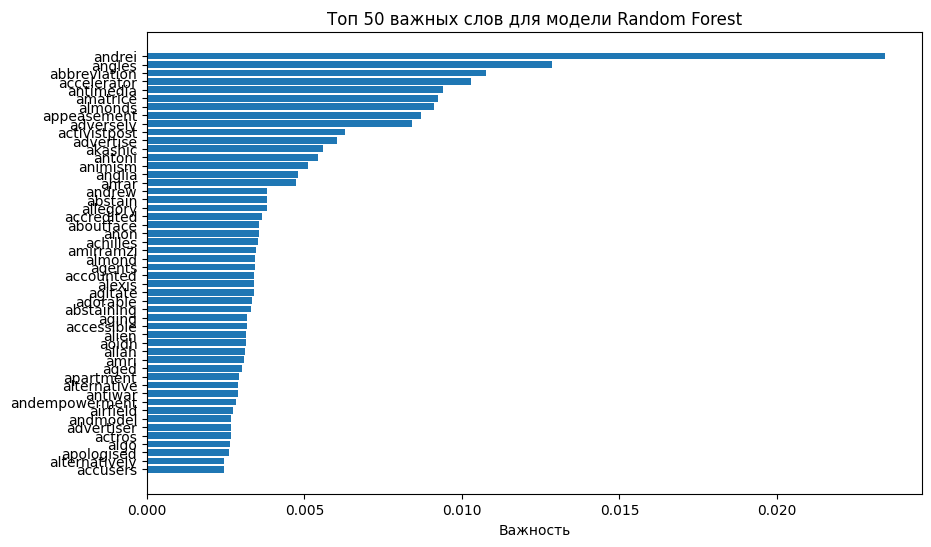


Топ 50 важных слов для модели Random Forest:
Слово: andrei, Важность: 0.0234
Слово: angles, Важность: 0.0129
Слово: abbreviation, Важность: 0.0108
Слово: accelerator, Важность: 0.0103
Слово: antimedia, Важность: 0.0094
Слово: amatrice, Важность: 0.0092
Слово: almonds, Важность: 0.0091
Слово: appeasement, Важность: 0.0087
Слово: adversely, Важность: 0.0084
Слово: activistpost, Важность: 0.0063
Слово: advertise, Важность: 0.0060
Слово: akashic, Важность: 0.0056
Слово: antoni, Важность: 0.0054
Слово: animism, Важность: 0.0051
Слово: anglia, Важность: 0.0048
Слово: ahrar, Важность: 0.0047
Слово: andrew, Важность: 0.0038
Слово: abstain, Важность: 0.0038
Слово: allegory, Важность: 0.0038
Слово: accredited, Важность: 0.0037
Слово: aboutface, Важность: 0.0035
Слово: anon, Важность: 0.0035
Слово: achilles, Важность: 0.0035
Слово: amirramzi, Важность: 0.0035
Слово: almond, Важность: 0.0034
Слово: agents, Важность: 0.0034
Слово: accounted, Важность: 0.0034
Слово: alexis, Важность: 0.0034
Слово: 

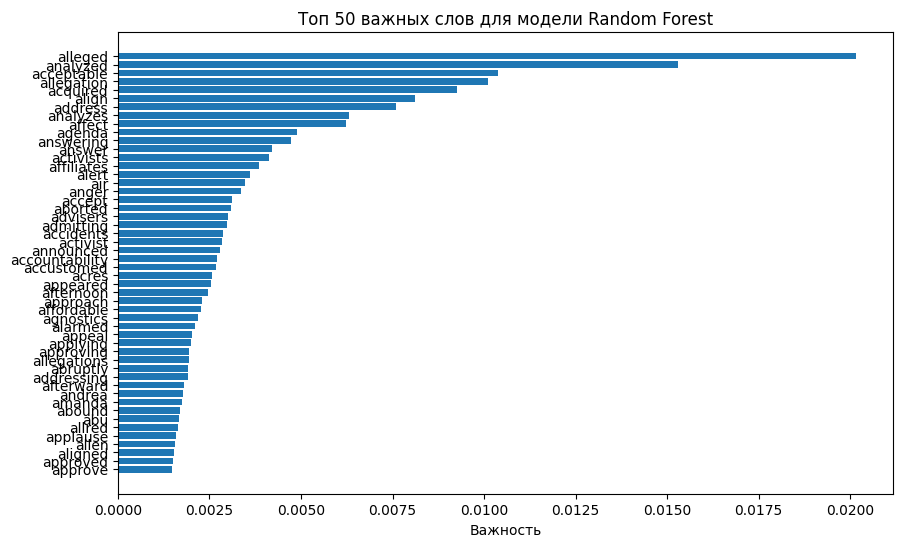


Топ 50 важных слов для модели Random Forest:
Слово: alleged, Важность: 0.0202
Слово: analyzed, Важность: 0.0153
Слово: acceptable, Важность: 0.0104
Слово: allegation, Важность: 0.0101
Слово: acquired, Важность: 0.0093
Слово: align, Важность: 0.0081
Слово: address, Важность: 0.0076
Слово: analyzes, Важность: 0.0063
Слово: affect, Важность: 0.0062
Слово: agenda, Важность: 0.0049
Слово: answering, Важность: 0.0047
Слово: answer, Важность: 0.0042
Слово: activists, Важность: 0.0041
Слово: affiliates, Важность: 0.0039
Слово: alert, Важность: 0.0036
Слово: air, Важность: 0.0035
Слово: anger, Важность: 0.0034
Слово: accept, Важность: 0.0031
Слово: aborted, Важность: 0.0031
Слово: advisers, Важность: 0.0030
Слово: admitting, Важность: 0.0030
Слово: accidents, Важность: 0.0029
Слово: activist, Важность: 0.0028
Слово: announced, Важность: 0.0028
Слово: accountability, Важность: 0.0027
Слово: accustomed, Важность: 0.0027
Слово: acres, Важность: 0.0026
Слово: appeared, Важность: 0.0025
Слово: afte

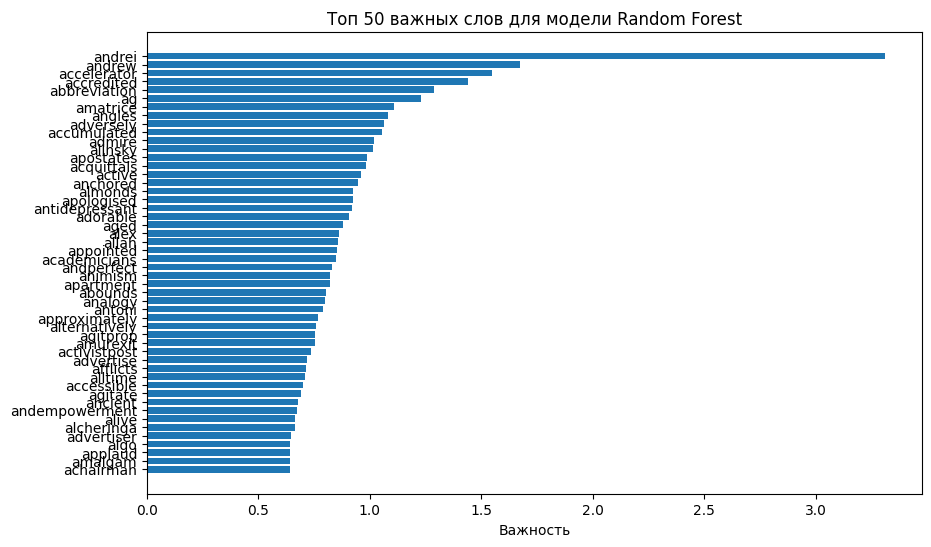


Топ 50 важных слов для модели Random Forest:
Слово: andrei, Важность: 3.3110
Слово: andrew, Важность: 1.6741
Слово: accelerator, Важность: 1.5482
Слово: accredited, Важность: 1.4403
Слово: abbreviation, Важность: 1.2885
Слово: ag, Важность: 1.2279
Слово: amatrice, Важность: 1.1091
Слово: angles, Важность: 1.0822
Слово: adversely, Важность: 1.0629
Слово: accumulated, Важность: 1.0530
Слово: admire, Важность: 1.0178
Слово: alinsky, Важность: 1.0146
Слово: apostates, Важность: 0.9864
Слово: acquittals, Важность: 0.9825
Слово: active, Важность: 0.9616
Слово: anchored, Важность: 0.9472
Слово: almonds, Важность: 0.9242
Слово: apologised, Важность: 0.9220
Слово: antidepressant, Важность: 0.9179
Слово: adorable, Важность: 0.9060
Слово: aged, Важность: 0.8786
Слово: alex, Важность: 0.8631
Слово: allah, Важность: 0.8570
Слово: appointed, Важность: 0.8509
Слово: academicians, Важность: 0.8486
Слово: andperfect, Важность: 0.8313
Слово: animism, Важность: 0.8200
Слово: apartment, Важность: 0.8197


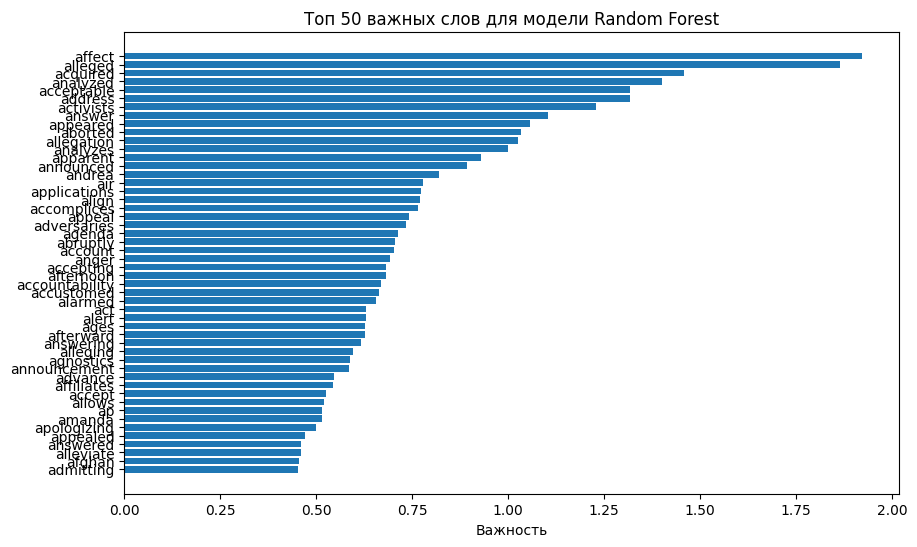


Топ 50 важных слов для модели Random Forest:
Слово: affect, Важность: 1.9221
Слово: alleged, Важность: 1.8628
Слово: acquired, Важность: 1.4584
Слово: analyzed, Важность: 1.4011
Слово: acceptable, Важность: 1.3182
Слово: address, Важность: 1.3166
Слово: activists, Важность: 1.2294
Слово: answer, Важность: 1.1024
Слово: appeared, Важность: 1.0579
Слово: aborted, Важность: 1.0332
Слово: allegation, Важность: 1.0267
Слово: analyzes, Важность: 1.0004
Слово: apparent, Важность: 0.9294
Слово: announced, Важность: 0.8914
Слово: andrea, Важность: 0.8205
Слово: air, Важность: 0.7782
Слово: applications, Важность: 0.7728
Слово: align, Важность: 0.7703
Слово: accomplices, Важность: 0.7642
Слово: appeal, Важность: 0.7420
Слово: adversaries, Важность: 0.7337
Слово: agenda, Важность: 0.7137
Слово: abruptly, Важность: 0.7060
Слово: account, Важность: 0.7014
Слово: anger, Важность: 0.6934
Слово: accepting, Важность: 0.6815
Слово: afternoon, Важность: 0.6813
Слово: accountability, Важность: 0.6677
Сло

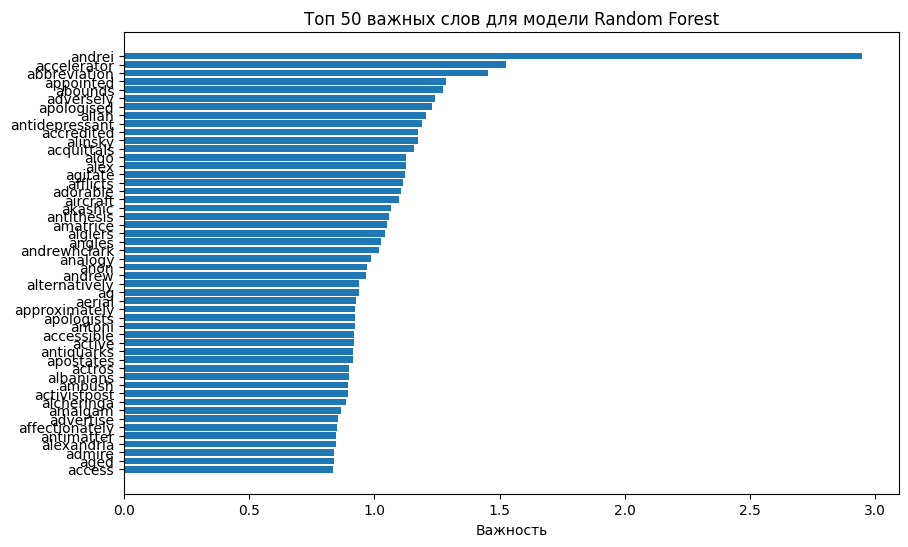


Топ 50 важных слов для модели Random Forest:
Слово: andrei, Важность: 2.9467
Слово: accelerator, Важность: 1.5237
Слово: abbreviation, Важность: 1.4550
Слово: appointed, Важность: 1.2871
Слово: abounds, Важность: 1.2733
Слово: adversely, Важность: 1.2441
Слово: apologised, Важность: 1.2292
Слово: allah, Важность: 1.2050
Слово: antidepressant, Важность: 1.1913
Слово: accredited, Важность: 1.1751
Слово: alinsky, Важность: 1.1747
Слово: acquittals, Важность: 1.1600
Слово: algo, Важность: 1.1265
Слово: alex, Важность: 1.1255
Слово: agitate, Важность: 1.1208
Слово: afflicts, Важность: 1.1144
Слово: adorable, Важность: 1.1052
Слово: aircraft, Важность: 1.1002
Слово: akashic, Важность: 1.0665
Слово: antithesis, Важность: 1.0587
Слово: amatrice, Важность: 1.0518
Слово: algiers, Важность: 1.0434
Слово: angles, Важность: 1.0275
Слово: andrewhclark, Важность: 1.0205
Слово: analogy, Важность: 0.9869
Слово: anon, Важность: 0.9693
Слово: andrew, Важность: 0.9668
Слово: alternatively, Важность: 0.94

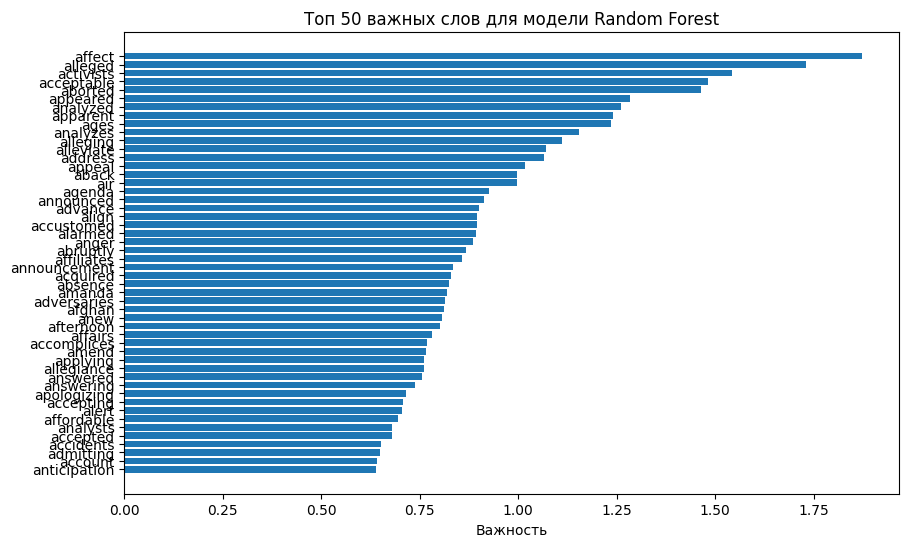


Топ 50 важных слов для модели Random Forest:
Слово: affect, Важность: 1.8735
Слово: alleged, Важность: 1.7316
Слово: activists, Важность: 1.5424
Слово: acceptable, Важность: 1.4828
Слово: aborted, Важность: 1.4637
Слово: appeared, Важность: 1.2845
Слово: analyzed, Важность: 1.2611
Слово: apparent, Важность: 1.2397
Слово: ages, Важность: 1.2362
Слово: analyzes, Важность: 1.1533
Слово: alleging, Важность: 1.1124
Слово: alleviate, Важность: 1.0704
Слово: address, Важность: 1.0650
Слово: appeal, Важность: 1.0178
Слово: aback, Важность: 0.9982
Слово: air, Важность: 0.9974
Слово: agenda, Важность: 0.9270
Слово: announced, Важность: 0.9144
Слово: advance, Важность: 0.8997
Слово: align, Важность: 0.8963
Слово: accustomed, Важность: 0.8955
Слово: alarmed, Важность: 0.8922
Слово: anger, Важность: 0.8853
Слово: abruptly, Важность: 0.8683
Слово: affiliates, Важность: 0.8578
Слово: announcement, Важность: 0.8356
Слово: acquired, Важность: 0.8294
Слово: absence, Важность: 0.8232
Слово: amanda, Важн

In [48]:
# Оценка уникальных слов для моделей
for model_name, model in models.items():
    if model_name in ['Random Forest', 'Logistic Regression', 'SVM']:
        print(f"\nОценка уникальных слов для класса FAKE в модели {model_name}:")
        evaluate_unique_words_importance(more_common_in_fake, vectorizer.get_feature_names_out(), model, 'Random Forest')
        
        print(f"\nОценка уникальных слов для класса REAL в модели {model_name}:")
        evaluate_unique_words_importance(more_common_in_real, vectorizer.get_feature_names_out(), model, 'Random Forest')